## Benchmarking

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from Benchmarking import *

In [8]:
def train(bases, smoothers, chm, gen_expts, datasets, model_root):

    for data_path in datasets:

        # data_path must end with generated_data
        data_path = data_path + "generated_data/"

        for gen_name in gen_expts:
            
            data_specs = "/".join(data_path.split("/")[-5:-2]) + "/chm{}/".format(chm)
            model_path = model_root + data_specs
            if not os.path.exists(model_path):
                os.makedirs(model_path)
                
            snp = data_path.split("/")[5]
            if snp == "full":
                M = 1000
            elif snp== "ukb":
                M = 30

            gens = gen_expts[gen_name]

            print("-"*100)
            print("Experiment details")
            print("Dataset used: {}".format(data_path))
            print("Generations used: {}".format(gens))
            print("Models will be stored at: {}".format(model_path))
            
            bm_train(bases, smoothers, model_path=model_path, data_path=data_path, gens=gens, chm=chm, M=M)

In [9]:
from Benchmarking import get_data, save_dict

def evaluate(bases, smoothers, chm, val_gens, data_path_fmt, model_path_fmt,
             set_names=["full", "ukb"], pop_names=["latino","five","seven"]):

    for set_name in set_names:
        M = 30 if set_name == "ukb" else 1000

        for pop_name in pop_names:

            data_path = data_path_fmt.format(chm,set_name,pop_name)
            model_root = model_path_fmt.format(chm,set_name,pop_name)

            print("Getting traintime data for model meta data")
            train_data_root = "/home/arvindsk/xgmix_expts/benchmark_data/{0}/{1}/{2}/generated_data/"
            train_data_path = train_data_root.format(set_name,"bal_admix",pop_name)
            _, meta, _ = get_data(train_data_path, M=M, gens=[0,2], chm=chm, verbose=False)
            
            print("Getting validation set that was separately generated")
            print("Val generations: ",val_gens, flush=True)
            val_paths = [data_path + "/chm{}/simulation_output/val/gen_".format(chm) + str(gen) + "/" for gen in val_gens] 
            X_val_files = [p + "mat_vcf_2d.npy" for p in val_paths]
            labels_val_files = [p + "mat_map.npy" for p in val_paths]
            train_val_files = [X_val_files, labels_val_files]
            X_val_raw, labels_val_raw = [load_np_data(f) for f in train_val_files]
            X_val, labels_window_val = data_process(X_val_raw, labels_val_raw, M, 0)
            X_v = np.array(X_val).astype("int8")
            y_v = np.array(labels_window_val).astype("int16")
            y_snp = labels_val_raw.copy() # glue the old train data with the new val data

            for b in bases:
                
                base_path = model_root + "base_models/" + b + "_retrained.pkl"
                base = pickle.load(open(base_path,"rb"))
                B_v = base.predict_proba(X_v)

                for s in smoothers:

                    smooth_path = model_root + "smoothers/" + b + "_" + s + ".pkl"
                    metric_path = model_root + "/" + b + "_" + s + ".benchmark"
                    
                    print("Base:", base_path)
                    print("Smooth:", smooth_path)

                    model = Gnomix(C=meta["C"], M=meta["M"], A=meta["A"])
                    model.base = base
                    model.smooth = pickle.load(open(smooth_path,"rb"))

                    metrics = bm_eval(model, val_data=(X_v, y_v), gens=val_gens, y_snp=y_snp,
                                      base_smooth_paths=[base_path, smooth_path], B_v=B_v)
                    save_dict(metrics,metric_path)
                    

In [29]:
model_root = '/home/wknd37/gnomix/benchmark/models/'

# set_names = ["ukb"]
# set_names = ["full"]
set_names = ["ukb", "full"]

bases = ["CovRSK","logreg"]
smoothers = ["crf", "xgb", "cnn"]

pop_names=["latino", "five", "seven"]

chm = 20
gen_expts = {
    "all" : [0,2,4,8,16,24,32,48,64,72,100]
}

data_path = "/home/arvindsk/xgmix_expts/benchmark_data/{}/bal_admix/{}/"
datasets_benchmark = [data_path.format(s,p) for s in set_names for p in pop_names]

In [30]:
# function of chm, set_name, pop_name
model_path_fmt = "/home/wknd37/gnomix/benchmark/models/{1}/bal_admix/{2}/chm{0}/"
data_path_fmt = "/home/arvindsk/xgmix_expts/benchmark_data/val/chm{0}/{1}/{2}/generated_data/"
val_gens = [2,4,8,12,16,20,30,40,50,60,70,80,90,100]

In [14]:
# train(bases, smoothers, chm, gen_expts, datasets=datasets_benchmark, model_root=model_root)

In [15]:
# evaluate(bases, smoothers, chm, val_gens=val_gens, data_path_fmt=data_path_fmt, model_path_fmt=model_path_fmt, 
#         set_names=set_names, pop_names=pop_names)

In [31]:
import pandas as pd

expt = ["model","base","smooth","pop_name","bal","snp"]
tuples = []
for set_name in set_names:
    for pop_name in pop_names:
        for base in bases:
            for smooth in smoothers:
                for bal in ["bal_admix"]:
                    model_root = model_path_fmt.format(chm,set_name,pop_name)
                    metric_path = model_root + "/" + base + "_" + smooth + ".benchmark"
                    M = load_dict(metric_path)
                    print(M)
                    skip_metrics = ["gen_performance"]
                    metric_names = [mkey for mkey in list(M.keys()) if mkey not in skip_metrics]
                    metrics = tuple([M[m] for m in metric_names])
                    tuples += [(base+"_"+smooth,base,smooth,pop_name,bal,set_name)+metrics]
                    
print(metric_names)
DF_us = pd.DataFrame(tuples, columns=expt+metric_names)
DF_us

{'base_val_acc': 93.86, 'base_val_acc_bal': 90.5, 'base_val_log_loss': 0.2, 'smooth_val_acc': 96.75, 'smooth_val_acc_bal': 95.17, 'smooth_val_log_loss': 0.1, 'base_training_time': 62.7380428314209, 'base_inference_time': 29.47674012184143, 'smooth_training_time': 4.725761890411377, 'smooth_inference_time': 2.234713315963745, 'training_time': 67.46380472183228, 'inference_time': 31.711453437805176, 'model_total_size_mb': 36.78, 'gen_performance': {'gens': [2, 4, 8, 12, 16, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'accs': [98.79, 99.47, 98.7, 98.81, 98.31, 98.08, 97.5, 97.1, 95.99, 95.69, 94.73, 94.45, 93.45, 93.42], 'accs_snp_lvl': [98.78, 99.46, 98.68, 98.77, 98.23, 97.97, 97.4, 96.85, 95.73, 95.26, 94.38, 94.11, 93.01, 93.0]}, 'val_acc_snp_lvl': 96.55}
{'base_val_acc': 93.86, 'base_val_acc_bal': 90.5, 'base_val_log_loss': 0.2, 'smooth_val_acc': 96.88, 'smooth_val_acc_bal': 95.29, 'smooth_val_log_loss': 0.09, 'base_training_time': 62.7380428314209, 'base_inference_time': 29.47674012184143

,model,base,smooth,pop_name,bal,snp,base_val_acc,base_val_acc_bal,base_val_log_loss,smooth_val_acc,smooth_val_acc_bal,smooth_val_log_loss,base_training_time,base_inference_time,smooth_training_time,smooth_inference_time,training_time,inference_time,model_total_size_mb,val_acc_snp_lvl
0,CovRSK_crf,CovRSK,crf,latino,bal_admix,ukb,93.86,90.50,0.20,96.75,95.17,0.10,62.738043,29.476740,4.725762,2.234713,67.463805,31.711453,36.78,96.55
1,CovRSK_xgb,CovRSK,xgb,latino,bal_admix,ukb,93.86,90.50,0.20,96.88,95.29,0.09,62.738043,29.476740,169.952745,1.351752,232.690788,30.828492,37.14,96.67
2,CovRSK_cnn,CovRSK,cnn,latino,bal_admix,ukb,93.86,90.50,0.20,96.55,94.61,0.11,62.738043,29.476740,16.496020,0.016329,79.234062,29.493069,36.77,96.36
3,logreg_crf,logreg,crf,latino,bal_admix,ukb,91.68,89.51,0.26,96.49,94.87,0.11,6.492308,5.759592,5.509839,2.215833,12.002147,7.975425,1.02,96.23
4,logreg_xgb,logreg,xgb,latino,bal_admix,ukb,91.68,89.51,0.26,96.56,94.86,0.10,6.492308,5.759592,161.120532,1.250732,167.612840,7.010324,1.37,96.30
5,logreg_cnn,logreg,cnn,latino,bal_admix,ukb,91.68,89.51,0.26,96.10,94.00,0.12,6.492308,5.759592,16.308484,0.018781,22.800792,5.778373,1.00,95.90
6,CovRSK_crf,CovRSK,crf,five,bal_admix,ukb,81.61,72.24,0.55,92.08,89.88,0.24,211.619118,78.751196,29.431986,6.845131,241.051104,85.596327,89.55,91.85
7,CovRSK_xgb,CovRSK,xgb,five,bal_admix,ukb,81.61,72.24,0.55,92.30,90.08,0.23,211.619118,78.751196,1095.626909,4.121991,1307.246027,82.873187,90.15,92.06
8,CovRSK_cnn,CovRSK,cnn,five,bal_admix,ukb,81.61,72.24,0.55,91.93,89.21,0.24,211.619118,78.751196,60.151077,0.041236,271.770195,78.792432,89.54,91.72
9,logreg_crf,logreg,crf,five,bal_admix,ukb,74.46,69.60,0.71,90.30,88.32,0.29,17.353612,8.819033,19.960229,6.669636,37.313840,15.488669,1.54,90.08


In [32]:
M_rfmix = load_dict("/home/arvindsk/xgmix_expts/benchmark_data/rfmix/metrics.pkl")
chm = "20"
M_rfmix = M_rfmix[chm]

D = {
    "pop_name": [] ,"snp": [],
    "training_time": [], "inference_time": [],
    "val_acc": [], "val_acc_snp_lvl": []
}
for m in list(M_rfmix.keys()):
    snp, pop_name = m.split("_")
    training_time = M_rfmix[m]["runtime"]
    val_acc = M_rfmix[m]["val_acc"]
    D["model"] = "rfmix"
    D["snp"].append(snp)
    D["pop_name"].append(pop_name)
    D["training_time"].append(training_time)
    D["inference_time"].append(training_time)    
    D["val_acc"].append(val_acc)
    D["val_acc_snp_lvl"].append(val_acc)
DF_rfmix = pd.DataFrame(D)
DF_rfmix.inference_time = np.zeros(len(DF_rfmix))
DF_rfmix

,pop_name,snp,training_time,inference_time,val_acc,val_acc_snp_lvl,model
0,latino,ukb,82.475601,0.0,95.58,95.58,rfmix
1,five,ukb,196.271353,0.0,90.28,90.28,rfmix
2,seven,ukb,241.045573,0.0,84.81,84.81,rfmix
3,latino,full,1594.307887,0.0,95.94,95.94,rfmix
4,five,full,4260.723067,0.0,90.76,90.76,rfmix
5,seven,full,5518.312196,0.0,88.18,88.18,rfmix


In [33]:
DF_elai = pd.DataFrame({
    "model": ["elai"]*2,
    "val_acc_snp_lvl": [88.32, 92.34],
    "training_time": [37219., 334003.],
    "inference_time": [0, 0],
    "pop_name": ["seven"]*2,
    "snp": ["ukb", "full"]
})
DF_elai

,model,val_acc_snp_lvl,training_time,inference_time,pop_name,snp
0,elai,88.32,37219.0,0,seven,ukb
1,elai,92.34,334003.0,0,seven,full


In [34]:
DF_loter = pd.DataFrame({
    "model": ["loter"]*1,
    "val_acc_snp_lvl": [83.85777636381365],
    "training_time": [8839.571]*1,
    "inference_time": [0],
    "pop_name": ["seven"]*1,
    "snp": ["ukb"]
})
DF_loter

,model,val_acc_snp_lvl,training_time,inference_time,pop_name,snp
0,loter,83.857776,8839.571,0,seven,ukb


In [35]:
DF_lainet = pd.DataFrame({
    "model": ["lainet"]*2,
    "val_acc_snp_lvl": [86.678902222118, 92.59156932963748],
    "training_time": [474.21, 4062.59],
    "inference_time": [0, 0],
    "pop_name": ["seven"]*2,
    "snp": ["ukb", "full"]
})
DF_lainet


,model,val_acc_snp_lvl,training_time,inference_time,pop_name,snp
0,lainet,86.678902,474.21,0,seven,ukb
1,lainet,92.591569,4062.59,0,seven,full


In [36]:
DF = DF_us.append(DF_rfmix)
DF = DF.append(DF_elai)
DF = DF.append(DF_loter)
# DF = DF.append(DF_lainet)
DF["dataset"] = DF.apply(lambda row: row.pop_name + "-" + row.snp, axis=1)
DF

,model,base,smooth,pop_name,bal,snp,base_val_acc,base_val_acc_bal,base_val_log_loss,smooth_val_acc,...,base_training_time,base_inference_time,smooth_training_time,smooth_inference_time,training_time,inference_time,model_total_size_mb,val_acc_snp_lvl,val_acc,dataset
0,CovRSK_crf,CovRSK,crf,latino,bal_admix,ukb,93.86,90.50,0.20,96.75,...,62.738043,29.476740,4.725762,2.234713,67.463805,31.711453,36.78,96.550000,NaN,latino-ukb
1,CovRSK_xgb,CovRSK,xgb,latino,bal_admix,ukb,93.86,90.50,0.20,96.88,...,62.738043,29.476740,169.952745,1.351752,232.690788,30.828492,37.14,96.670000,NaN,latino-ukb
2,CovRSK_cnn,CovRSK,cnn,latino,bal_admix,ukb,93.86,90.50,0.20,96.55,...,62.738043,29.476740,16.496020,0.016329,79.234062,29.493069,36.77,96.360000,NaN,latino-ukb
3,logreg_crf,logreg,crf,latino,bal_admix,ukb,91.68,89.51,0.26,96.49,...,6.492308,5.759592,5.509839,2.215833,12.002147,7.975425,1.02,96.230000,NaN,latino-ukb
4,logreg_xgb,logreg,xgb,latino,bal_admix,ukb,91.68,89.51,0.26,96.56,...,6.492308,5.759592,161.120532,1.250732,167.612840,7.010324,1.37,96.300000,NaN,latino-ukb
5,logreg_cnn,logreg,cnn,latino,bal_admix,ukb,91.68,89.51,0.26,96.10,...,6.492308,5.759592,16.308484,0.018781,22.800792,5.778373,1.00,95.900000,NaN,latino-ukb
6,CovRSK_crf,CovRSK,crf,five,bal_admix,ukb,81.61,72.24,0.55,92.08,...,211.619118,78.751196,29.431986,6.845131,241.051104,85.596327,89.55,91.850000,NaN,five-ukb
7,CovRSK_xgb,CovRSK,xgb,five,bal_admix,ukb,81.61,72.24,0.55,92.30,...,211.619118,78.751196,1095.626909,4.121991,1307.246027,82.873187,90.15,92.060000,NaN,five-ukb
8,CovRSK_cnn,CovRSK,cnn,five,bal_admix,ukb,81.61,72.24,0.55,91.93,...,211.619118,78.751196,60.151077,0.041236,271.770195,78.792432,89.54,91.720000,NaN,five-ukb
9,logreg_crf,logreg,crf,five,bal_admix,ukb,74.46,69.60,0.71,90.30,...,17.353612,8.819033,19.960229,6.669636,37.313840,15.488669,1.54,90.080000,NaN,five-ukb


In [37]:
import matplotlib as mpl
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [21]:
import matplotlib.pyplot as plt
def performance_speed(df, pop_name, snp, log_speed=True, legend=True, name=None, include_loter=False, fmt="pdf"):
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    plt.figure(figsize=(16/3, 4))

    df = df[df.pop_name == pop_name]
    df = df[df.snp == snp]
    
#     colors = ["green"]*9 + ["black", "gray"]
#     colors = [s+c for c in ["blue", "green", "orange"] for s in ["dark", "", "light"]]
#     colors[1] = "royalblue"; colors[5] = "limegreen"
#     colors[8] = "yellow"
#     colors += ["black", "gray"]

    attr_values = df.model_total_size_mb
    attrs_cmap = truncate_colormap(mpl.cm.get_cmap("Reds") , 0.6, 0.95)
    norm = mpl.colors.Normalize(vmin=min(attr_values), vmax=max(attr_values))
    cmap = mpl.cm.get_cmap(attrs_cmap)
    colors = [cmap(norm(at)) for at in attr_values]
    colors[-1] = "gray"
    colors[-2] = "gray"
#     colors[-4] = "gray"
    
    pipe_time = np.array(df.training_time.values) + np.array(df.inference_time.values)
    
    df["speed"] = 1/pipe_time

    shapes = {
        "P": [0,3],
        "^": [1,4],
        "s": [2,5],
        "o": [6, 7]
    }

    if include_loter:
        colors[-3] = "gray"
        shapes["o"] += [8]

    for shape in shapes:
        plt.scatter(
            np.array(df["speed"])[shapes[shape]],
            np.array(df["val_acc_snp_lvl"])[shapes[shape]],
            c = np.array(colors, dtype="object")[shapes[shape]],
            marker=shape,
            s=120, alpha=0.75)
    
    if log_speed:
        plt.xscale("log")
        
    if legend:
        patches = []
        for i, color in enumerate(colors[-len(df.model):]):
            model_string = list(df.model)[i].replace("_","-").replace("randomstringkernel", "rsk")
            patches.append(mpatches.Patch(color=color, label=model_string))
        plt.legend(handles=patches)
        
    plt.xlabel("Speed (models/second)")
    plt.ylabel("Accuracy (%)")
    
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), )
    cbar.ax.set_ylabel("Model Size (MB)")
    
    for s, lab in [("^", "XGB"), ("P","CRF"), ("s", "CNN")]:
        plt.scatter([],[],marker=s,edgecolors='gray', color="white",label=lab)
    
    plt.legend(title="Smoother",loc="lower left")
    
    if name is not None:
        plt.savefig(name+'.'+fmt, format=fmt)
        
    plt.show()

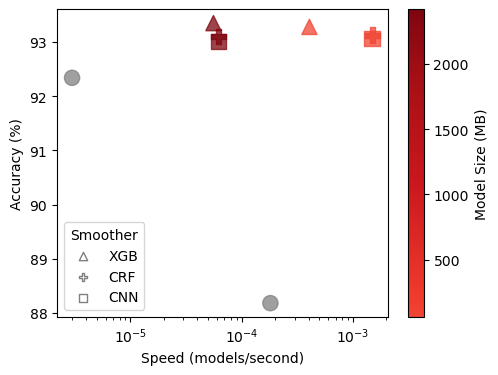

In [32]:
performance_speed(DF, "seven", "full", log_speed=True, legend=False, name="performance_speed")

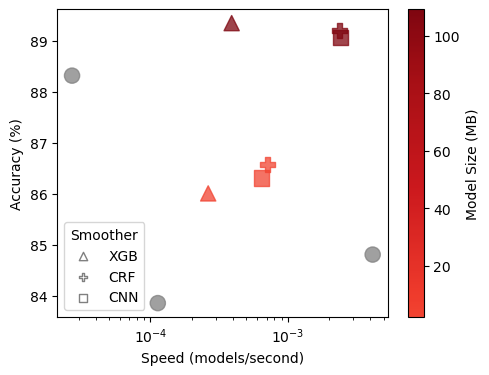

In [23]:
performance_speed(DF, "seven", "ukb", log_speed=True, legend=False, include_loter=True, name="performance_speed_array")

In [24]:
def plot_acc_vs_gen(chm, set_name, pop_name, bal, base, smooth, df_elai=None,
                    title=False, fz=None, figsize=None, name=None, fmt="svg"):
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    if fz is not None:
        fig, ax = plt.subplots(figsize=figsize)
        mpl.rcParams['xtick.labelsize'] = fz 
        mpl.rcParams['ytick.labelsize'] = fz 
        mpl.rcParams['legend.fontsize'] = 18
        mpl.rcParams['legend.title_fontsize'] = 18
        plt.xticks(fontsize=fz)
        plt.yticks(fontsize=fz)

    
#     cmap = { 0:'darkgreen', 1:'tab:blue',  2:'y', 3:'g'}
#     lmap = { 0:'-', 1:'--', 2:':', 3:'-.' }

    cmap = { 0: "#e71919", 1: 'gray'}
    set_name_map = {"ukb": "array data", "full":"whole genome"}
    lmap = { 0:'-', 1:'--'}
    acc_str = lambda acc: " (" + str(acc) + "%)"
    
    
    for l, data_type in enumerate(set_name):
        for i, b in enumerate(base):
            for j, s in enumerate(smooth):
                    model_root = model_path_fmt.format(chm,data_type,pop_name)
                    metric_path = model_root + "/" + b + "_" + s + ".benchmark"
                    M = load_dict(metric_path)
                    val_acc = M["smooth_val_acc"]
                    m_name = b + "_" + s
                    G = M["gen_performance"]
                    plt.plot(G["gens"], G["accs_snp_lvl"], linestyle=lmap[l%len(lmap)], color=cmap[j%len(cmap)])
#                                      label= "Gnomix"+"\n"+set_name_map[data_type]) 

        # RFmix
        M_gen_rfmix_raw = load_dict("/home/arvindsk/xgmix_expts/benchmark_data/rfmix/metrics_gen_wise.pkl")
        G_rfmix = M_gen_rfmix_raw[chm][data_type+"_"+pop_name]
        plt.plot(G["gens"], G_rfmix["genwise_val_acc"], linestyle=lmap[l%len(lmap)], color="#383838")
#                          label= "RFMix"+"\n"+set_name_map[data_type])
    
#     # ELAI
#     elai = {
#         "full_seven": [0.9647847162912352, 0.9717922293690616, 0.9532395977901142, 
#                         0.9559750987509341, 0.9486789059997864, 0.9511597563253976,
#                         0.9411326331803138, 0.9237755217785844, 0.9122701038219281,
#                         0.9012977407387638, 0.8884707283548628,0.8754089156079855,
#                         0.8763316029678659,0.8629970241272552],
#         "ukb_seven": [0.964738549667787, 0.9718450565496505, 0.9659384477142536,
#                       0.940345302793354, 0.9377241033705147, 0.9286346866656875,
#                       0.9135457797285271, 0.8859924053257761, 0.8629642989830567,
#                       0.8346279128038085,0.8141724051529735, 0.7966642618304979,
#                       0.7802566550600921,0.7670491364190117]
#     }
#     G_elai = elai[set_name+"_"+pop_name]
#     plt.plot(G["gens"], [g*100 for g in G_elai], linestyle="--", color="gray", label= "elai")
    
#     loter = {
#         "ukb_seven": [0.8680338952297842,0.8663199094514381,
#                       0.8699174435583511, 0.8447152645175784, 0.864501162097478,
#                       0.8414514554298896, 0.855045619886123,0.8378982019889579,
#                       0.841542176794339,0.8155775062856946, 0.8152956220461556,
#                       0.8089505266159203,0.799941031113108, 0.8108988759190938]
#     }
#     G_loter = loter[set_name+"_"+pop_name]
#     plt.plot(G["gens"], [g*100 for g in G_loter], linestyle="--", color="darkgray", label= "loter")


    
#     data = "ancestry:" + pop_name + ", snps:" +set_name
#     print(data)


    plt.plot([],[], linestyle="-", color="black", label="Whole genome")
    plt.plot([],[], linestyle="--", color="black", label="Array genotype")
    
    plt.legend()
    plt.xlabel("Generation", fontsize=fz)
    plt.ylabel("Accuracy (%)", fontsize=fz)

    plt.legend(loc="lower left")
               
    if name is not None:
        fig.savefig(name+'.'+fmt, format=fmt)
               
    plt.show()

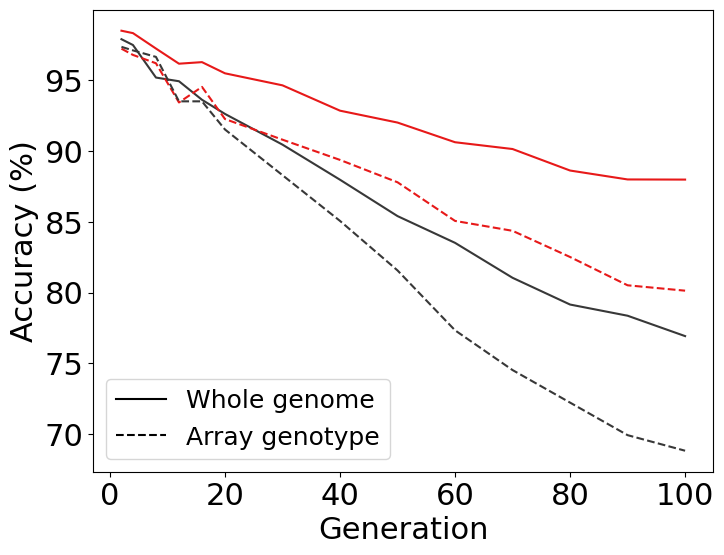

In [25]:
base = ["CovRSK"]
smooth = ["xgb"]
plot_acc_vs_gen(chm, ["full", "ukb"], pop_name, bal, base, smooth, fz=22, figsize=(8,6), name = "gen_acc", fmt="pdf")


In [182]:
chm = "20"
pop_name = "seven" 
bal = "bal_admix"
base = ["CovRSK"]
smooth = ["xgb"]

plot_acc_vs_gen(chm, "ukb", pop_name, bal, base, smooth, fz=22, figsize=(8,6))

KeyError: 'smooth_val_acc'

In [49]:
def pretty_df(df, pop_name, snp):
    df = df[df.pop_name == pop_name]
    df = df[df.snp == snp]
    df = df[["model", "val_acc_snp_lvl", "smooth_val_log_loss", "base_val_acc", "training_time", "inference_time", "model_total_size_mb"]]
    df.model = [m.replace("_", "-") for m in df.model.values.tolist()]
    
    # integer time and size
    
    for attr in ["training_time", "inference_time"]:
        values = df[attr]
        for v in values:
            df[attr] = np.array([int(np.round(v)) if not np.isnan(v) else v for v in values])

    df.columns = [["model", "accuracy (%)", "log loss", "base accuracy (%)", "training time (s)", "inference time (s)", "model size (mb)"]]
    
    snp = "whole genome" if snp=="full" else "array genotype"
    
    pop_name = "7-ancestry" if pop_name == "seven" else pop_name
    pop_name = "5-ancestry" if pop_name == "five" else pop_name
    pop_name = "Latin American" if pop_name == "latino" else pop_name
    
    latex_out = df.to_latex(
        index=False, na_rep="-", float_format="{:0.2f}".format, 
        column_format='l'+'r'*6,
        label="tab:"+pop_name+"-"+snp,
        caption="{} ({})".format(pop_name,snp)
    )
    
    # 3 line header
    swap_out = "model & accuracy (\\%) & log loss & base accuracy (\\%) & training time (s) & inference time (s) & model size (mb) \\"
    swap_in = "&  & log & base & training & inference & model \\\ model & accuracy & loss & accuracy & time & time &  size \\\ &  (\%) &  & (\%) & (s) & (s) & (mb) \\"
    latex_out = latex_out.replace(swap_out, swap_in)
    
    print(latex_out)

    return latex_out


In [50]:
pretty_df(DF, "seven", "full")

\begin{table}
\centering
\caption{7-ancestry (whole genome)}
\label{tab:7-ancestry-whole genome}
\begin{tabular}{lrrrrrr}
\toprule
     &  & log & base & training & inference & model \\ model & accuracy & loss & accuracy & time & time &  size \\ &  (\%) &  & (\%) & (s) & (s) & (mb) \\
\midrule
CovRSK-crf &        93.10 &     0.21 &             88.17 &             11392 &               4731 &         2419.55 \\
CovRSK-xgb &        93.35 &     0.19 &             88.17 &             13200 &               4727 &         2420.36 \\
CovRSK-cnn &        93.01 &     0.22 &             88.17 &             11379 &               4722 &         2419.51 \\
logreg-crf &        93.13 &     0.20 &             87.52 &               635 &                 30 &           58.13 \\
logreg-xgb &        93.28 &     0.20 &             87.52 &              2436 &                 26 &           58.97 \\
logreg-cnn &        93.07 &     0.21 &             87.52 &               655 &                 21 &           

'\\begin{table}\n\\centering\n\\caption{7-ancestry (whole genome)}\n\\label{tab:7-ancestry-whole genome}\n\\begin{tabular}{lrrrrrr}\n\\toprule\n     &  & log & base & training & inference & model \\\\ model & accuracy & loss & accuracy & time & time &  size \\\\ &  (\\%) &  & (\\%) & (s) & (s) & (mb) \\\\\n\\midrule\nCovRSK-crf &        93.10 &     0.21 &             88.17 &             11392 &               4731 &         2419.55 \\\\\nCovRSK-xgb &        93.35 &     0.19 &             88.17 &             13200 &               4727 &         2420.36 \\\\\nCovRSK-cnn &        93.01 &     0.22 &             88.17 &             11379 &               4722 &         2419.51 \\\\\nlogreg-crf &        93.13 &     0.20 &             87.52 &               635 &                 30 &           58.13 \\\\\nlogreg-xgb &        93.28 &     0.20 &             87.52 &              2436 &                 26 &           58.97 \\\\\nlogreg-cnn &        93.07 &     0.21 &             87.52 &             

In [43]:
pretty_df(DF, "five", "full")

\begin{table}
\centering
\caption{5-ancestry (whole-genome)}
\label{tab:5-ancestry-whole-genome}
\begin{tabular}{lrrrrrr}
\toprule
     &  & log & base & training & inference & model \\ model & accuracy & loss & accuracy & time & time &  size \\ &  (\%) &  & (\%) & (s) & (s) & (mb) \\
\midrule
CovRSK-crf &        95.16 &     0.14 &             91.50 &             11519 &               5004 &         2257.62 \\
CovRSK-xgb &        95.40 &     0.13 &             91.50 &             12608 &               5001 &         2258.22 \\
CovRSK-cnn &        95.07 &     0.14 &             91.50 &             11549 &               4997 &         2257.61 \\
logreg-crf &        95.19 &     0.14 &             91.40 &               433 &                 23 &           41.57 \\
logreg-xgb &        95.40 &     0.12 &             91.40 &              1344 &                 20 &           42.18 \\
logreg-cnn &        95.09 &     0.14 &             91.40 &               465 &                 17 &           

,model,accuracy (%),log loss,base accuracy (%),training time (s),inference time (s),model size (mb)
24,CovRSK-crf,95.16,0.14,91.5,11519,5004,2257.62
25,CovRSK-xgb,95.40,0.13,91.5,12608,5001,2258.22
26,CovRSK-cnn,95.07,0.14,91.5,11549,4997,2257.61
27,logreg-crf,95.19,0.14,91.4,433,23,41.57
28,logreg-xgb,95.40,0.12,91.4,1344,20,42.18
29,logreg-cnn,95.09,0.14,91.4,465,17,41.57
4,rfmix,90.76,NaN,NaN,4261,0,NaN


In [44]:
pretty_df(DF, "latino", "full")

\begin{table}
\centering
\caption{Latino (whole-genome)}
\label{tab:Latino-whole-genome}
\begin{tabular}{lrrrrrr}
\toprule
     &  & log & base & training & inference & model \\ model & accuracy & loss & accuracy & time & time &  size \\ &  (\%) &  & (\%) & (s) & (s) & (mb) \\
\midrule
CovRSK-crf &        97.63 &     0.07 &             97.52 &              3241 &               1933 &         1074.02 \\
CovRSK-xgb &        97.70 &     0.06 &             97.52 &              3399 &               1932 &         1074.38 \\
CovRSK-cnn &        97.29 &     0.08 &             97.52 &              3252 &               1931 &         1074.01 \\
logreg-crf &        97.69 &     0.06 &             97.55 &                76 &                 14 &           25.02 \\
logreg-xgb &        97.79 &     0.06 &             97.55 &               230 &                 13 &           25.38 \\
logreg-cnn &        97.29 &     0.08 &             97.55 &                86 &                 12 &           25.01 \\

,model,accuracy (%),log loss,base accuracy (%),training time (s),inference time (s),model size (mb)
18,CovRSK-crf,97.63,0.07,97.52,3241,1933,1074.02
19,CovRSK-xgb,97.70,0.06,97.52,3399,1932,1074.38
20,CovRSK-cnn,97.29,0.08,97.52,3252,1931,1074.01
21,logreg-crf,97.69,0.06,97.55,76,14,25.02
22,logreg-xgb,97.79,0.06,97.55,230,13,25.38
23,logreg-cnn,97.29,0.08,97.55,86,12,25.01
3,rfmix,95.94,NaN,NaN,1594,0,NaN


In [39]:
pretty_df(DF, "seven", "ukb")

\begin{table}
\centering
\caption{7-ancestry (array)}
\label{tab:7-ancestry-array}
\begin{tabular}{lrrrrrr}
\toprule
     &  & log & base & training & inference & model \\ model & accuracy & loss & accuracy & time & time &  size \\ &  (\%) &  & (\%) & (s) & (s) & (mb) \\
\midrule
CovRSK-crf &        89.20 &     0.33 &             77.97 &               324 &                 97 &          108.53 \\
CovRSK-xgb &        89.35 &     0.33 &             77.97 &              2470 &                 93 &          109.35 \\
CovRSK-cnn &        89.07 &     0.35 &             77.97 &               324 &                 87 &          108.50 \\
logreg-crf &        86.57 &     0.40 &             67.90 &              1402 &                 11 &            2.06 \\
logreg-xgb &        86.01 &     0.42 &             67.90 &              3792 &                  7 &            2.91 \\
logreg-cnn &        86.31 &     0.41 &             67.90 &              1555 &                  1 &            2.06 \\
     

,model,accuracy (%),log loss,base accuracy (%),training time (s),inference time (s),model size (mb)
12,CovRSK-crf,89.200000,0.33,77.97,324,97,108.53
13,CovRSK-xgb,89.350000,0.33,77.97,2470,93,109.35
14,CovRSK-cnn,89.070000,0.35,77.97,324,87,108.50
15,logreg-crf,86.570000,0.40,67.90,1402,11,2.06
16,logreg-xgb,86.010000,0.42,67.90,3792,7,2.91
17,logreg-cnn,86.310000,0.41,67.90,1555,1,2.06
2,rfmix,84.810000,NaN,NaN,241,0,NaN
0,elai,88.320000,NaN,NaN,37219,0,NaN
0,loter,83.857776,NaN,NaN,8840,0,NaN


In [46]:
pretty_df(DF, "five", "ukb")

\begin{table}
\centering
\caption{5-ancestry (array)}
\label{tab:5-ancestry-array}
\begin{tabular}{lrrrrrr}
\toprule
     &  & log & base & training & inference & model \\ model & accuracy & loss & accuracy & time & time &  size \\ &  (\%) &  & (\%) & (s) & (s) & (mb) \\
\midrule
CovRSK-crf &        91.85 &     0.24 &             81.61 &               241 &                 86 &           89.55 \\
CovRSK-xgb &        92.06 &     0.23 &             81.61 &              1307 &                 83 &           90.15 \\
CovRSK-cnn &        91.72 &     0.24 &             81.61 &               272 &                 79 &           89.54 \\
logreg-crf &        90.08 &     0.29 &             74.46 &                37 &                 15 &            1.54 \\
logreg-xgb &        89.99 &     0.29 &             74.46 &               887 &                 13 &            2.15 \\
logreg-cnn &        90.00 &     0.29 &             74.46 &                70 &                  9 &            1.54 \\
     

,model,accuracy (%),log loss,base accuracy (%),training time (s),inference time (s),model size (mb)
6,CovRSK-crf,91.85,0.24,81.61,241,86,89.55
7,CovRSK-xgb,92.06,0.23,81.61,1307,83,90.15
8,CovRSK-cnn,91.72,0.24,81.61,272,79,89.54
9,logreg-crf,90.08,0.29,74.46,37,15,1.54
10,logreg-xgb,89.99,0.29,74.46,887,13,2.15
11,logreg-cnn,90.00,0.29,74.46,70,9,1.54
1,rfmix,90.28,NaN,NaN,196,0,NaN


In [48]:
pretty_df(DF, "latino", "ukb")

\begin{table}
\centering
\caption{Latino (array)}
\label{tab:Latino-array}
\begin{tabular}{lrrrrrr}
\toprule
     &  & log & base & training & inference & model \\ model & accuracy & loss & accuracy & time & time &  size \\ &  (\%) &  & (\%) & (s) & (s) & (mb) \\
\midrule
CovRSK-crf &        96.55 &     0.10 &             93.86 &                67 &                 32 &           36.78 \\
CovRSK-xgb &        96.67 &     0.09 &             93.86 &               233 &                 31 &           37.14 \\
CovRSK-cnn &        96.36 &     0.11 &             93.86 &                79 &                 29 &           36.77 \\
logreg-crf &        96.23 &     0.11 &             91.68 &                12 &                  8 &            1.02 \\
logreg-xgb &        96.30 &     0.10 &             91.68 &               168 &                  7 &            1.37 \\
logreg-cnn &        95.90 &     0.12 &             91.68 &                23 &                  6 &            1.00 \\
     rfmix & 

,model,accuracy (%),log loss,base accuracy (%),training time (s),inference time (s),model size (mb)
0,CovRSK-crf,96.55,0.10,93.86,67,32,36.78
1,CovRSK-xgb,96.67,0.09,93.86,233,31,37.14
2,CovRSK-cnn,96.36,0.11,93.86,79,29,36.77
3,logreg-crf,96.23,0.11,91.68,12,8,1.02
4,logreg-xgb,96.30,0.10,91.68,168,7,1.37
5,logreg-cnn,95.90,0.12,91.68,23,6,1.00
0,rfmix,95.58,NaN,NaN,82,0,NaN


In [45]:
fig = barplot_metric_vs_data(
    DF, dataset="seven-full",
    metrics = ["val_acc_snp_lvl", "training_time", "inference_time"],
    metr_labls = ["Accuracy (%)", "Training time (s)" , "Inference time (s)"],
    y_lims = ((88,94), None, None),
    log_metrics = (False, True, True),
    fz = 26
)

NameError: name 'barplot_metric_vs_data' is not defined

In [429]:
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.patches as mpatches

def barplot_metric_vs_data(DF, metrics, bal="bal_admix", rfmix_line=False, dataset=None, 
                           metr_labls=None, log_metrics=None, y_lims=None, fz=22, figsize = [8, 6],
                           rot="90", right_legend=True, n_models=11):

    DF = DF.copy()
    fig, ax = plt.subplots(1, len(metrics), figsize=figsize)
    
    if n_models == 14:
        colors = [s+c for c in ["blue", "green", "orange", "red"] for s in ["dark", "", "light"]]
        colors[1] = "royalblue"; colors[5] = "limegreen"
        colors[10] = "coral"; colors[11] = "lightcoral"; colors[8] = "yellow"
        colors += ["black", "gray"]
    
    if n_models == 11:
        colors = [s+c for c in ["blue", "green", "orange"] for s in ["dark", "", "light"]]
        colors[1] = "royalblue"; colors[5] = "limegreen"
    #     colors[10] = "coral"; colors[11] = "lightcoral"; 
        colors[8] = "yellow"
        colors += ["black", "gray"]

    if fz is not None:
        mpl.rcParams['xtick.labelsize'] = fz 
        mpl.rcParams['ytick.labelsize'] = fz 
        mpl.rcParams['legend.fontsize'] = fz
    
    for i, metric in enumerate(metrics):
        
        log_metric = False if log_metrics is None else log_metrics[i]
        metr_labl = metr_labls[i] if metr_labls is not None else metrics[i]
    
        if dataset is None:    
            datasetorder = CategoricalDtype(
                ['latino-full', 'latino-ukb', 'five-full', 'five-ukb', 'seven-full', 'seven-ukb'],
                ordered=True
            )
            DF["dataset"] = DF["dataset"].astype(datasetorder)
            DF = DF.sort_values(by=['dataset'])
        else:
            DF = DF[DF.dataset == dataset]

        df = DF[( (DF.bal == bal) | (DF.bal.isnull()) )]

        # rfmix
        if rfmix_line:
            df_rfmix = df[df.model == "rfmix"].copy()
            df_rfmix.plot(y=metric, x="dataset", ax=ax[i], c="gray", label="rfmix")
            df = df[df.model != "rfmix"]

        if dataset is None:
            df = df[[metric, "model", "dataset"]]
            df = df.pivot(index="dataset", columns='model', values=metric)
            df.plot.bar(ax=ax[i])
        else:
            metric_model = list(zip(df[metric], df.model, colors[-len(df.model):]))
            sortd = sorted(metric_model, key = lambda x:x[0])
            metr, mdl, cols = list(zip(*sortd))
            ax[i].bar(x=mdl, height=metr, color=cols)
            if log_metric:
                ax[i].set_yscale("log")

        if y_lims is not None:
            ax[i].set_ylim(y_lims[i])
        ax[i].set_ylabel(metr_labl, fontsize=fz)
        # ax[i].set_xlabel("model", fontsize=fz)
        ax[i].set_xticks([])
        for tick in ax[i].get_xticklabels():
            tick.set_rotation(rot)
            

    print("data:", dataset)
    fig.tight_layout(pad=2.0)    

    if right_legend:
        patches = []
        for i, color in enumerate(colors[-len(df.model):]):
            model_string = list(df.model)[i].replace("_","-").replace("randomstringkernel", "rsk")
            patches.append(mpatches.Patch(color=color, label=model_string))
        ax[-1].legend(handles=patches, bbox_to_anchor=(1.25, 1.1), loc='upper left')

    plt.show()
        
    return fig

data: seven-ukb


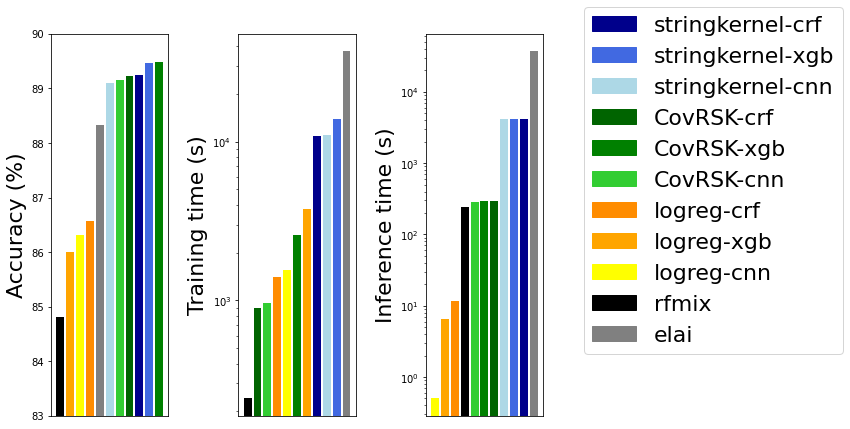

In [17]:
fig = barplot_metric_vs_data(
    DF, dataset="seven-ukb",
    metrics = ["val_acc_snp_lvl", "training_time", "inference_time"],
    metr_labls = ["Accuracy (%)", "Training time (s)" , "Inference time (s)"],
    y_lims = ((83,90), None, None),
    log_metrics = (False, True, True)
)

In [52]:
fig.savefig('results.svg', format='svg')